<a href="https://colab.research.google.com/github/Kurooto/Python/blob/master/%E5%8C%BA%E5%88%86%E7%B7%9A%E5%BD%A2%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd, numpy as np
from copy import deepcopy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

In [ ]:
df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
df = df[['Date_reported', 'Country_code','Country', 'New_cases', 'New_deaths']]
df.Date_reported = pd.to_datetime(df.Date_reported)
df = df.set_index('Date_reported')

In [ ]:
country_codes = df.reset_index()[['Country_code','Country']].drop_duplicates()

In [ ]:
len(country_codes)

237

In [ ]:
code2county = dict(zip(country_codes.Country_code, country_codes.Country))
county2code = dict(zip(country_codes.Country, country_codes.Country_code))

In [ ]:
county2code['Germany']

'DE'

In [ ]:
total_cases = df[['Country_code','New_cases']].groupby('Country_code').sum().sort_values('New_cases', ascending=False)

In [ ]:
total_cases.iloc[:20]

,New_cases
Country_code,
US,44408612
IN,34037592
BR,21597949
GB,8317443
RU,7925176
TR,7570932
FR,6854885
IR,5754047
AR,5268653


In [ ]:
total_cases.index.to_list().index('JP')

24

In [ ]:
code2county['CA']

'Canada'

In [ ]:
code2county['CN']

'China'

In [ ]:
code2county['CH']

'Switzerland'

In [ ]:
list(total_cases.index).index('CN')

107

In [ ]:
#行列Wの作成(切片は行列に組み込まなくても勝手にやってくれる)
code = 'JP'
number_of_day = len(df[df.Country_code == code])
W = np.ones((1,number_of_day))
row_hoge = np.arange(1, number_of_day+1)
W[0] = row_hoge
W = W.T

In [ ]:
#とりあえず回帰分析をやってみる
X_regression = (np.log(df[df.Country_code == code].New_cases+1e-1)/np.log(10)).values
X_regression.reshape(1,number_of_day)
model_lr = LinearRegression()
model_lr.fit(W, X_regression)
X_pred = model_lr.predict(W)
mean_squared_error(X_regression, X_pred)

0.48850130239104

In [ ]:
#window sizeとか作ってくぎりながら回帰分析してみたい

window_size = 50
coef_list = [[]*i for i in range(3)]

for i in range(window_size, number_of_day-window_size+1):
  W_0 = W[i-window_size:i+window_size].reshape(2*window_size,1)
  X_0 = X_regression[i-window_size:i+window_size]
  model_lr.fit(W_0,X_0)
  coef_list[0].append(model_lr.coef_[0])

  W_1 = W[i-window_size:i].reshape(window_size,1)
  X_1 = X_regression[i-window_size:i]
  model_lr.fit(W_1,X_1)
  coef_list[1].append(model_lr.coef_[0])
  
  W_2 = W[i:i+window_size].reshape(window_size,1)
  X_2 = X_regression[i:i+window_size]
  model_lr.fit(W_2,X_2)
  coef_list[2].append(model_lr.coef_[0])

coef_list[0] = np.array(coef_list[0])
coef_list[0].shape


(553,)

In [ ]:
#MDL変化統計量に出てくるRと\sigma_minを計算したい

window_size = 14
coef_norm_list = []
sigma_list = []

for i in range(window_size, number_of_day-window_size+1):
  W_0 = W[i-window_size:i+window_size].reshape(2*window_size,1)
  X_0 = X_regression[i-window_size:i+window_size]
  model_lr.fit(W_0,X_0)
  coef_norm_list.append(np.sqrt(model_lr.coef_[0]**2+model_lr.intercept_**2)/(2*window_size))
  sigma_list.append(mean_squared_error(X_0, model_lr.predict(W_0)))

  W_1 = W[i-window_size:i].reshape(window_size,1)
  X_1 = X_regression[i-window_size:i]
  model_lr.fit(W_1,X_1)
  coef_norm_list.append(np.sqrt(model_lr.coef_[0]**2+model_lr.intercept_**2)/(window_size))
  sigma_list.append(mean_squared_error(X_1, model_lr.predict(W_1)))

  W_2 = W[i:i+window_size].reshape(window_size,1)
  X_2 = X_regression[i:i+window_size]
  coef_norm_list.append(np.sqrt(model_lr.coef_[0]**2+model_lr.intercept_**2)/(window_size))
  sigma_list.append(mean_squared_error(X_2, model_lr.predict(W_2)))

coef_norm_list = np.array(coef_norm_list)
sigma_list = np.array(sigma_list)

R = np.max(coef_norm_list)
sigma_min = np.min(sigma_list)
sigma_min

0.0012045284784901397

In [ ]:
#MDL変化統計量を計算してアラートを出したい

def calculate_threshold(delta, window_size):
  return (2+1.5+delta)*np.log(2*window_size)+np.log(1/delta)

window_size = 14
delta = 0.05
alarm_list = []
MDL_list = []
const = -np.log(R/sigma_min) - np.log(math.gamma(window_size-1)/(math.gamma(window_size*0.5-1)**2)) + window_size*np.log(2)
epsilon = calculate_threshold(delta, window_size)


for i in range(window_size, number_of_day-window_size+1):
  W_0 = W[i-window_size:i+window_size].reshape(2*window_size,1)
  X_0 = X_regression[i-window_size:i+window_size]
  model_lr.fit(W_0,X_0)
  sigma_0 = mean_squared_error(X_0, model_lr.predict(W_0))

  W_1 = W[i-window_size:i].reshape(window_size,1)
  X_1 = X_regression[i-window_size:i]
  model_lr.fit(W_1,X_1)
  sigma_1 = mean_squared_error(X_1, model_lr.predict(W_1))

  W_2 = W[i:i+window_size].reshape(window_size,1)
  X_2 = X_regression[i:i+window_size]
  model_lr.fit(W_2,X_2)
  sigma_2 = mean_squared_error(X_2, model_lr.predict(W_2))

  phi = window_size*np.log((sigma_0**2)/(sigma_1*sigma_2)) + const
  MDL_list.append(phi)
  if phi>epsilon:
    alarm_list.append(i+1)

alarm_list = np.array(alarm_list)
MDL_list = np.array(MDL_list)

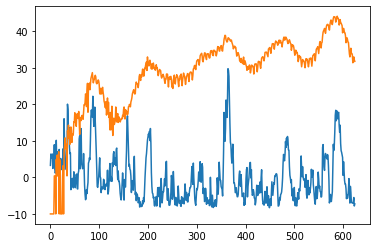

In [ ]:
#MDL変化統計量の推移をグラフにしたい

t = np.arange(len(MDL_list))

plt.plot(t, MDL_list)
plt.plot(t, X_regression[window_size:number_of_day-window_size+1]*10)
plt.show()

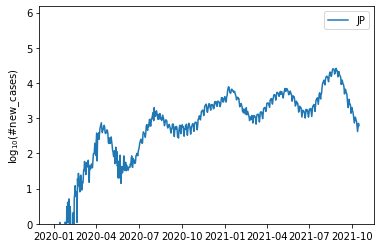

In [ ]:
    code = 'JP'
    ax = None
    fontsize=10
    cumulative = True
    

#def plot(code, ax=None, fontsize=10):
    if ax is None:
        ax = plt.subplot()
    X = (np.log(df[df.Country_code == code].New_cases+1e-1)/np.log(10))
    ax.plot(X, label=code)
    ylim = np.log(df.New_cases.max())/np.log(10)
    ax.set_ylim(0,ylim*1.1)
    ax.set_ylabel('$\log_{10}$(#new_cases)', fontsize=fontsize)
    ax.legend(fontsize=fontsize)

In [ ]:
code = 'JP'
ax = None
fontsize=10
cumulative = True

def plot(code, ax=None, fontsize=10, cumulative=False):
    if ax is None:
        ax = plt.subplot()
    X = df[df.Country_code == code].New_cases
    X = X.cumsum() if cumulative else X
    label = 'tatal_cases' if cumulative else 'new_cases'
    X = (np.log(X+1e-1)/np.log(10))
    ax.plot(X, label=code)
    ylim = np.log(df.New_cases.max())/np.log(10)
    ax.set_ylim(0,ylim*1.1)
    ax.set_ylabel(f'$\log_{{10}}$(#{label})', fontsize=fontsize)
    ax.legend(fontsize=fontsize)

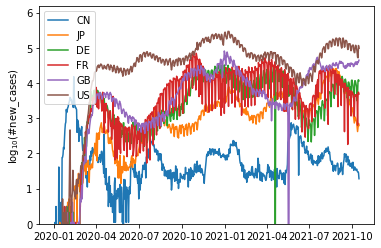

In [ ]:
ax = plt.subplot()
for code in ['CN', 'JP', 'DE', 'FR', 'GB', 'US']:
    plot(code, ax)

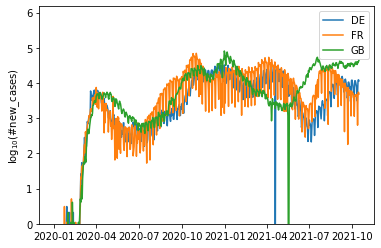

In [ ]:
ax = plt.subplot()
for code in ['DE', 'FR', 'GB']:
    plot(code, ax)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


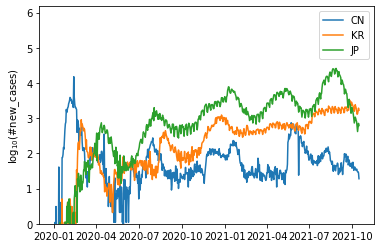

In [ ]:
ax = plt.subplot()
for code in ['CN', 'KR', 'JP']:
    plot(code, ax)

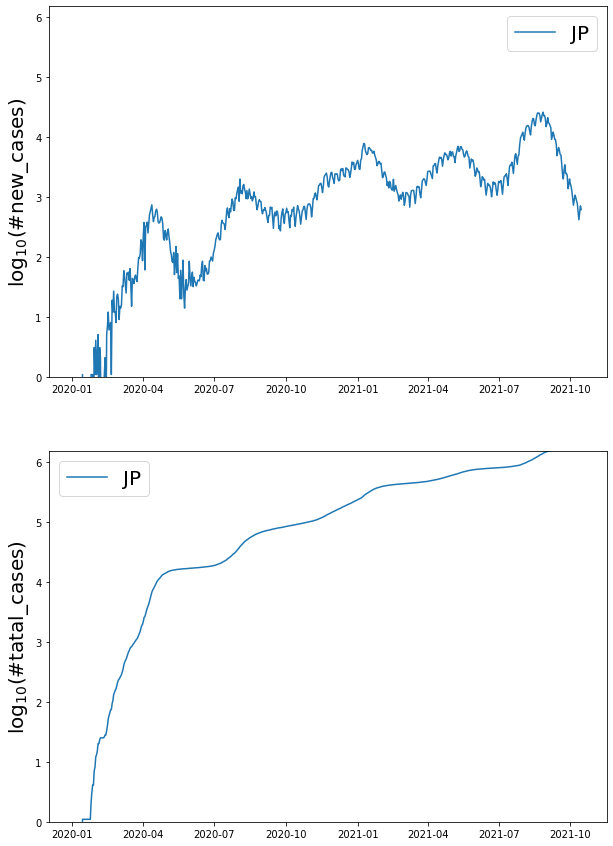

In [ ]:
nrows, ncols = 2,1
fig, axes = plt.subplots(nrows,ncols, figsize=(10,15))
fontsize = 20
plot('JP', axes[0], fontsize=fontsize)
plot('JP', axes[1], cumulative=True, fontsize=fontsize)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


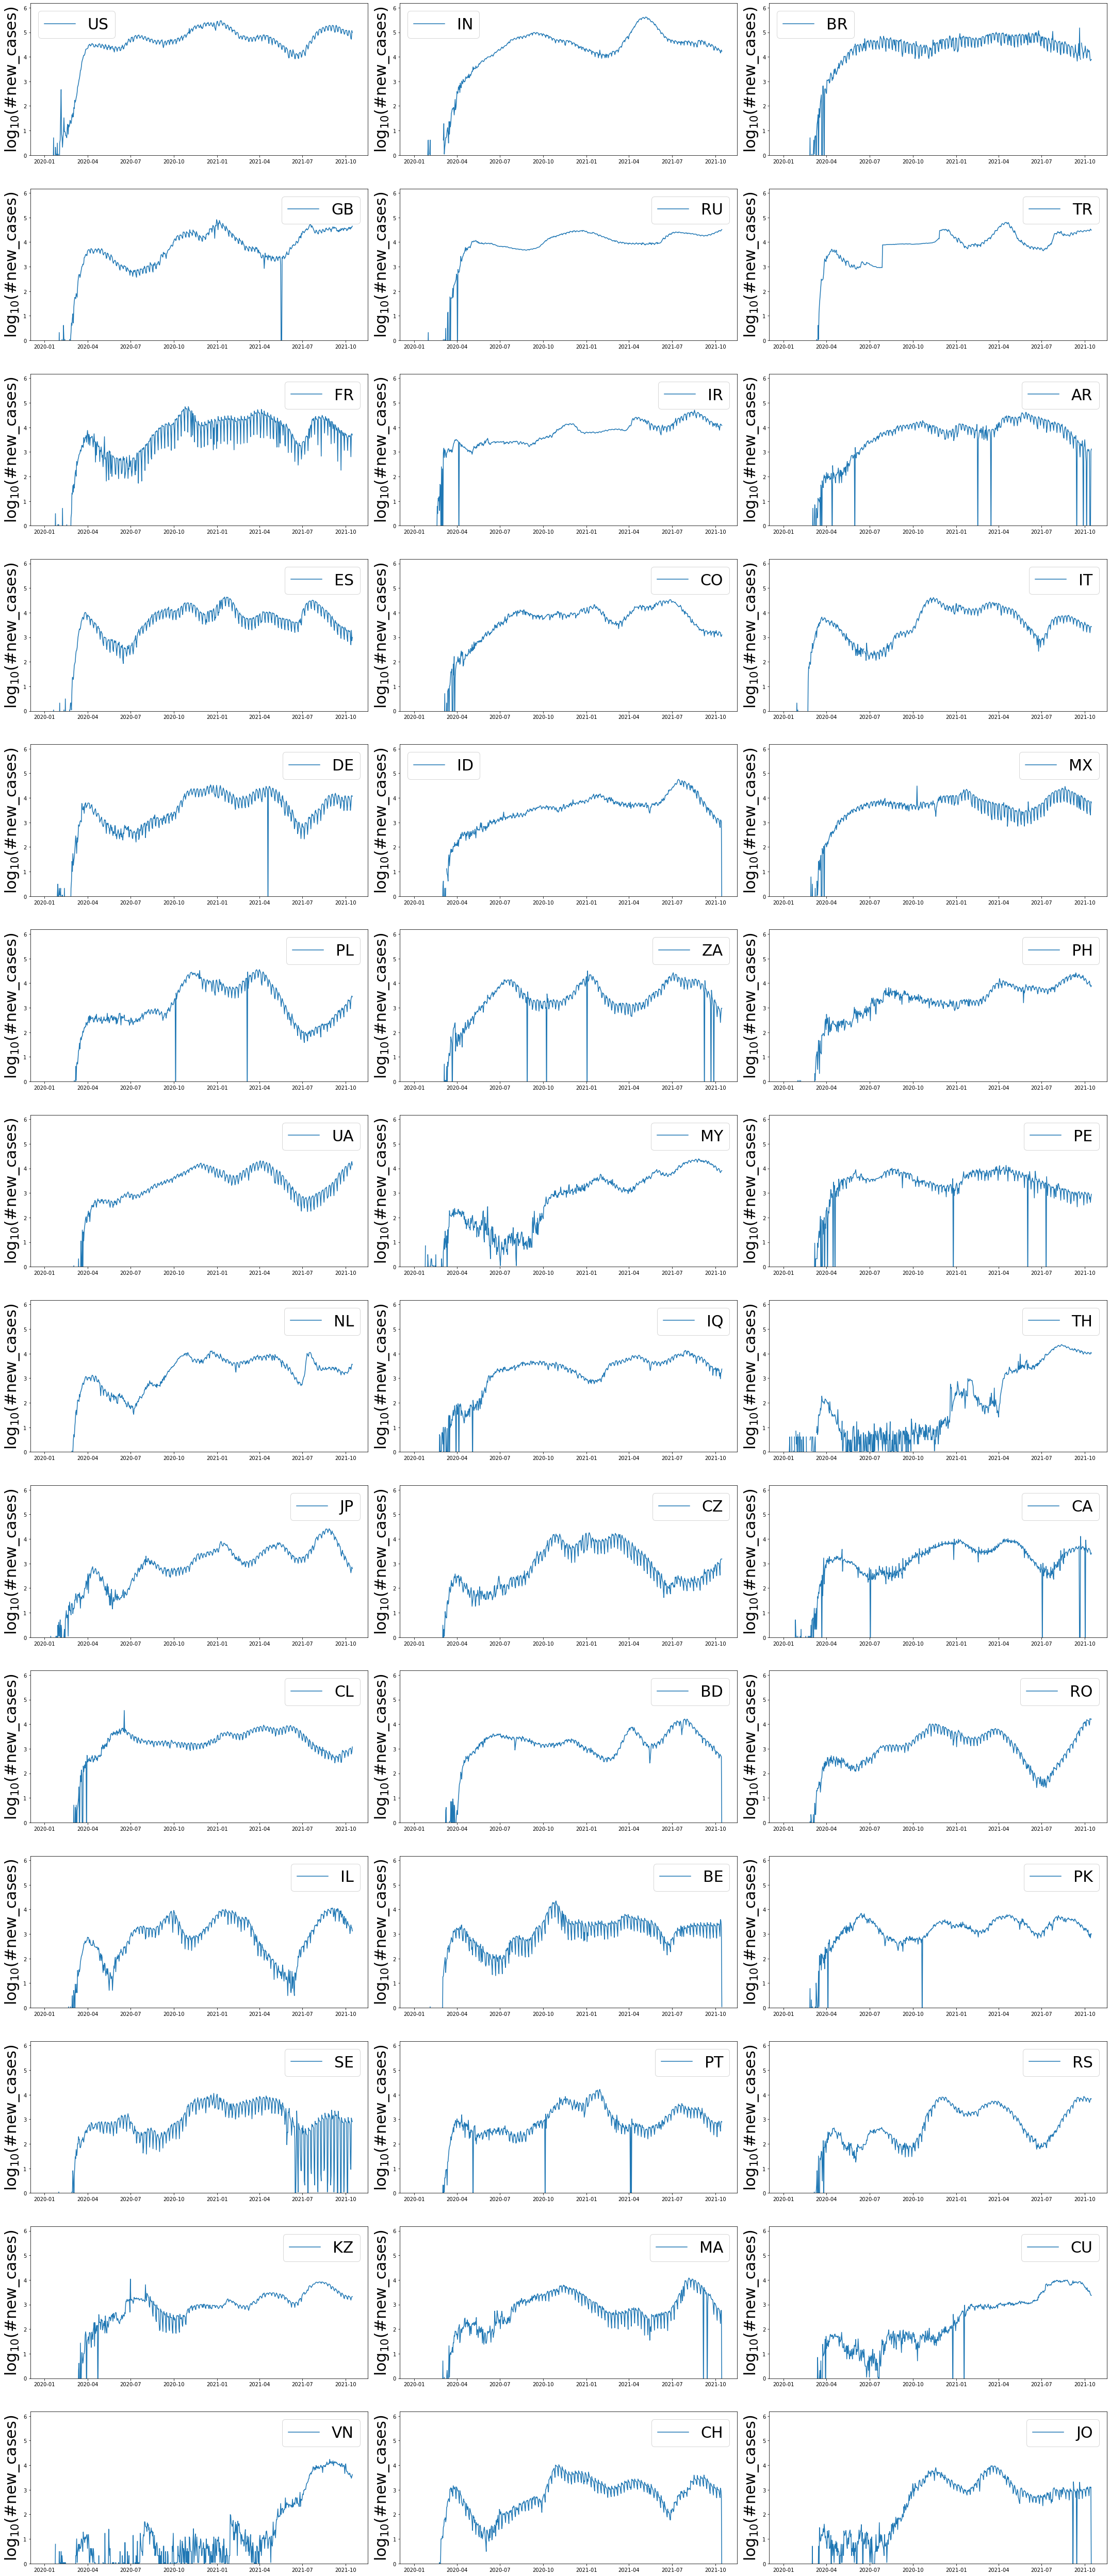

In [ ]:
nrows, ncols = 14,3
fig, axes = plt.subplots(nrows,ncols, figsize=(30,70))
for code,ax in zip(total_cases.index, axes.flat):
    plot(code, ax, fontsize=30)
plt.tight_layout()

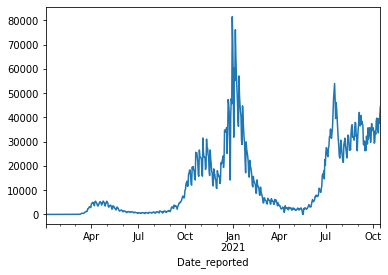

In [ ]:
df[df.Country_code == 'GB'].New_cases.plot()

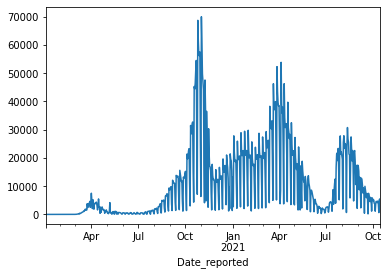

In [ ]:
df[df.Country_code == 'FR'].New_cases.plot()

In [ ]:
code2county['PK']

'Pakistan'

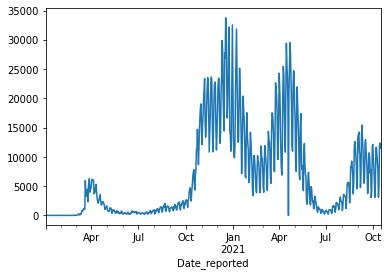

In [ ]:
df[df.Country_code == 'DE'].New_cases.plot()

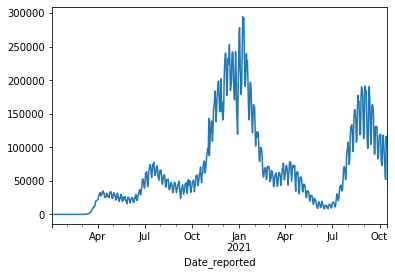

In [ ]:
df[df.Country_code == 'US'].New_cases.plot()

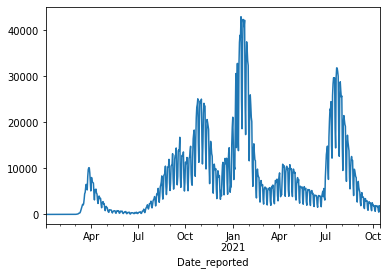

In [ ]:
df[df.Country_code == county2code['Spain']].New_cases.plot()

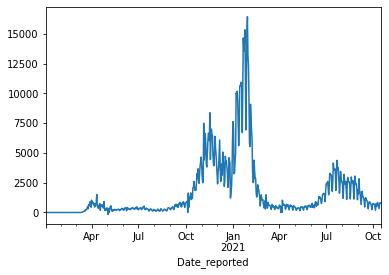

In [ ]:
df[df.Country_code == 'PT'].New_cases.plot()

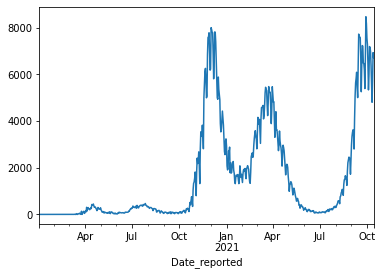

In [ ]:
df[df.Country_code == 'RS'].New_cases.plot()

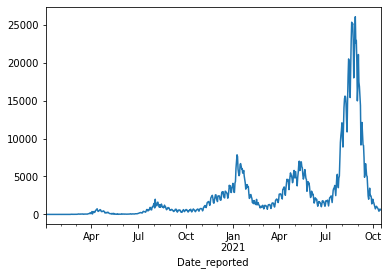

In [ ]:
df[df.Country_code == 'JP'].New_cases.plot()